In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import thunder as td
from fish.util.fileio import load_image
from fish.image.vol import filter_flat, unfilter_flat, dff
from glymur import jp2k
%matplotlib inline

In [2]:
def guess_experimenter(fname):
        if fname.find('Yu') > 0:
            return 'yu'
        elif fname.find('davis') > 0:
            return 'davis'
        else:
            return ''
        
def tidy_up_mask(im):
    from skimage.morphology import disk, binary_opening, remove_small_objects, remove_small_holes
    im_ = im.copy()
    im_ = binary_opening(im_, disk(3))
    im_ = remove_small_objects(im_, min_size=500)
    im_ = remove_small_holes(im_, min_size=5000)
    return im_

In [3]:
base_dirs = ('/groups/ahrens/ahrenslab/davis/data/spim/raw/20160607/5dpf_cy171xcy221_f1_omr_1_20160607_183009/',)

# do different things to the directories depending on whether data are davis' or yu's
paths = dict()
cur_exp = -1
paths['base'] = base_dirs[cur_exp]
experimenter = guess_experimenter(paths['base'])

bidirectional_stack=False

if experimenter is 'yu':
    print('These data are from Yu.')
    paths['raw'] = paths['base'] + 'raw/'
    paths['proj'] = paths['base'] + 'projections/'
    paths['reg'] = paths['base']    

elif experimenter is 'davis':
    print('These data are from Davis')    
    paths['raw'] = paths['base']
    paths['proc'] = paths['raw'].replace('raw', 'proc')
    paths['proj'] = paths['proc'] + 'proj/'
    paths['reg'] = paths['proc'] + 'reg/'

# Get the camera background image
background_im_fname = paths['raw'] + 'Background_0.tif'
background_im = jp2k.Jp2k(background_im_fname)[:]

fnames = glob(paths['raw'] + 'TM*')
fnames.sort()    
print('Num raw images: {0}'.format(len(fnames)))

from fish.image.vol import get_stack_freq
fs_im = 1 / get_stack_freq(paths['raw'])[0]    
print('Sampling rate:  {0} Hz'.format(1 / fs_im))

# set correct aspect ratio for plotting
from fish.image.vol import get_metadata
exp_data = get_metadata(paths['raw'] + 'ch0.xml')
bidirectional_stack = exp_data['bidirectional_stack'] == 'T'
z_step = exp_data['z_step']
aspect = (int(z_step / .406), 1, 1)

from os.path import exists
if not exists(paths['proj']):
    from os import makedirs
    makedirs(paths['proj'])
else:
    print('Num existing projections: {0}'.format(len(glob(paths['proj'] + 't*'))))
print('Bidirectional stack : {0}'.format(bidirectional_stack))

These data are from Davis
Num raw images: 5000
Sampling rate:  2.12 Hz
Num existing projections: 5000
Bidirectional stack : False


In [4]:
plr = slice(0, None)
ims = td.images.fromlist(fnames[plr], accessor=load_image, engine=sc, npartitions=len(fnames[plr])).median_filter(size=(1,3,3)).astype('float32')
if bidirectional_stack:
    from fish.image.vol import rearrange_bidirectional_stack
    ims = ims.map(rearrange_bidirectional_stack)

In [5]:
%%time
do_registration = False

if not exists(paths['reg']):
    ref_range = (len(fnames) // 2) + np.arange(-5,5)
    ref = td.images.fromlist(np.array(fnames)[ref_range], accessor=load_image)
    ref = ref.median_filter(size=(1,3,3)).mean().toarray().astype('uint16')

    if bidirectional_stack:
        ref = rearrange_bidirectional_stack(ref)

    # save reference image to disk 
    from skimage.io import imsave

    makedirs(paths['reg'])
    imsave(paths['reg'] + 'anat_reference.tif', ref, compress=1)
else:
    from skimage.io import imread
    ref = imread(paths['reg'] + 'anat_reference.tif')

try:
    affs = np.load(paths['reg'] + 'regparams_affine.npy')
    affs = affs[plr]
    print('Registration params found')
except(FileNotFoundError):
    print('Registration params not found, performing registration')
    do_registration = True

if do_registration:
    from fish.image.alignment import estimate_translation
    reg = ims.map(lambda v: estimate_translation(ref.max(0), v.max(0))).toarray()
    affs = np.array([r.affine for r in reg])
    np.save(paths['reg'] + 'regparams_affine.npy', affs)

Registration params found
CPU times: user 1.52 s, sys: 431 ms, total: 1.95 s
Wall time: 3.09 s


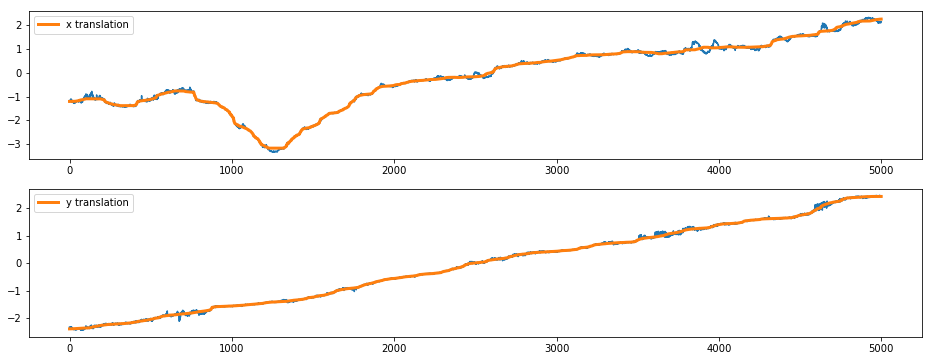

In [6]:
from scipy.ndimage.filters import median_filter
fig, axs = plt.subplots(nrows=2, figsize=(16,6))
x_trans_raw = affs[:, -2, -1]
y_trans_raw = affs[:, 0, -1]
x_trans = median_filter(x_trans_raw, size=200)
y_trans = median_filter(y_trans_raw, size=200)
z_trans = np.zeros(x_trans.shape)
trans = np.vstack([z_trans, y_trans, x_trans])

axs[0].plot(x_trans_raw)
axs[0].plot(x_trans, linewidth=3, label = 'x translation')
axs[0].legend()
axs[1].plot(y_trans_raw)
axs[1].plot(y_trans, linewidth=3, label = 'y translation')
axs[1].legend()

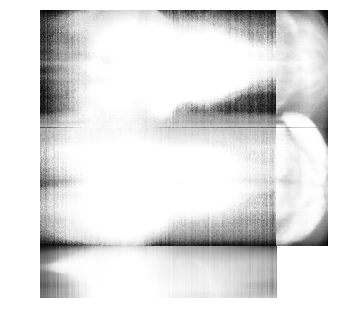

In [7]:
from fish.image.vol import proj_plot
fill_val = np.median(background_im)
mask = ref > fill_val
proj_plot(mask, np.mean, aspect=aspect);

In [8]:
from scipy.ndimage.interpolation import shift

# important to apply -1 * translation
ims_registered = ims.map(lambda v: shift(v[1], -trans[:, v[0][0]], cval=fill_val), with_keys=True).astype('float32')

In [9]:
# generate local projections 
def my_proj(v, slab_size = 4, axis=0):    
    from fish.image.vol import sub_proj    
    from numpy import amax
    # number of planes per projection        
    n_slabs = int(np.ceil(v.shape[axis] / slab_size))    
    chopped = sub_proj(v, axis, amax, n_slabs)
    return chopped

from skimage.exposure import rescale_intensity as rescale

# save the images
def save_ims(kv, dest_dir):
    from skimage.io import imsave
    key = kv[0][0]
    val = kv[1]    
    fname = 't_{:06d}.tif'.format(key)
    imsave(dest_dir + fname, val, compress=1)

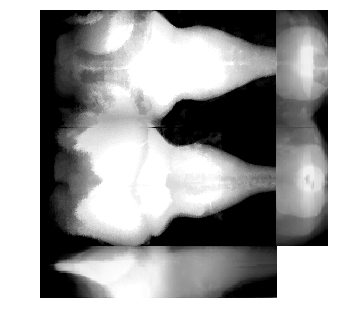

In [14]:
mask = ref > fill_val * 1.03
#mask = np.array([tidy_up_mask(m) for m in mask])

y_lim = np.abs(np.array([min(trans[1,:]), max(trans[1,:])])).astype('int')
x_lim = np.abs(np.array([min(trans[2,:]), max(trans[2,:])])).astype('int')
mask = np.array([tidy_up_mask(m) for m in mask])

mask[:,:,:x_lim[0]] = False
mask[:,:,-x_lim[1]:] = False
mask[:,:y_lim[0],:] = False
mask[:,-y_lim[1]:,:] = False

proj_plot(mask, np.mean, aspect=aspect, interpolation='None');

In [15]:
%%time
# take 300s baseline
baseline_window = int(300 / fs_im)
baseline_offset = 10
mydff = lambda v: dff(v, baseline_window, percentile=20, baseline_offset=baseline_offset)
ds = 2

# subtract camera background, clip off negative values
ims_reg_bs = ims_registered.map(lambda v: np.clip(v - fill_val, a_min=0, a_max=None))

# apply mask
ims_reg_masked = ims_reg_bs.map(lambda v: v * mask)

# uniform filter and downsampling
ims_ds = ims_reg_masked.uniform_filter(size=(1,ds,ds))[:,:,::ds,::ds]

#take dff only of masked pixels by flattening masked images
mask_ds = sc.broadcast(mask[:,::ds,::ds])
ims_flat = ims_ds.map(lambda v: filter_flat(v, mask_ds.value))
ims_dff = ims_flat.map_as_series(mydff, value_size=len(fnames[plr]), dtype='float64').map(lambda v: unfilter_flat(v, mask_ds.value))

# get min and max
bounds = ims_dff.map(lambda v: np.array([v.min(), v.max()])).toarray()

CPU times: user 33.3 s, sys: 3.5 s, total: 36.8 s
Wall time: 1h 6min 32s


## Apply dff-based mask and rescale

In [16]:
out_range = 'uint16'
mn, mx = bounds.min(), bounds.max()

# assuming 2-color imaging here, so we have 1 y-projection for each color
y_slab_size = ims_dff.shape[2] // 2
slabs_z = ims_dff.map(lambda v: rescale(v, (mn,mx), out_range)).map(lambda v: my_proj(v, axis=0)).astype('int16')
slabs_y = ims_dff.map(lambda v: rescale(v, (mn,mx), out_range)).map(lambda v: my_proj(v, axis=1, slab_size=y_slab_size)).astype('int16')

## Save projections

In [17]:
%%time
tmp_paths = {}
tmp_paths['y'] = '/groups/ahrens/ahrenslab/davis/data/spim/proc/20170519/th1gc6s_gfaprgeco_7dpf_f1_omr_black_1_20170519_192713/projs_y/'
tmp_paths['z'] = '/groups/ahrens/ahrenslab/davis/data/spim/proc/20170519/th1gc6s_gfaprgeco_7dpf_f1_omr_black_1_20170519_192713/projs_z/'
slabs_z.tordd().foreach(lambda v: save_ims(v, tmp_paths['z']))
slabs_y.tordd().foreach(lambda v: save_ims(v, tmp_paths['y']))

CPU times: user 1.6 s, sys: 557 ms, total: 2.16 s
Wall time: 1min 21s


## Save metadata

In [18]:
print(mn)
print(mx)

-0.572763741016
28.0445976257


In [19]:
metadata = {}
metadata['raw_data_path'] = paths['raw']
metadata['dff_lims'] = [float(mn), float(mx)]
metadata['spatial_downsampling'] = ds
metadata['dff_window'] = baseline_window

In [20]:
import json
#metadata_fname = paths['proj'] + 'metadata.json'
metadata_fname = tmp_paths['y'] + 'metadata.json'
with open(metadata_fname, 'w') as fp:
    json.dump(metadata, fp)
    
metadata_fname = tmp_paths['z'] + 'metadata.json'
with open(metadata_fname, 'w') as fp:
    json.dump(metadata, fp)